### We begin with boilerplate:

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 5]

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import random
import pandas as pd
import os
import sys

In [4]:
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

In [5]:
# point at library; I need some lessons on doing good PYTHONPATHs:
REPO_DIR = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(REPO_DIR, 'lib'))

# Covid epidemic simulator

In [6]:
from disease import Covid
from outbreak import Outbreak
from population.networks.household_workplace import HouseholdWorkplacePopulation
from population.covid import PersonCovid
import society
import config

### Baseline config of the simulation

In [7]:
config.print_baseline_config()

DAILY_TEST_CAPACITY_PER_HEAD 0.0075
DAYS_BEFORE_INFECTIOUS 4
DAYS_INFECTIOUS_TO_SYMPTOMS 2
DAYS_OF_SYMPTOMS 5
DURATION_OF_ISOLATION 10
MEAN_NETWORK_SIZE 9.0
PROB_APPLY_FOR_TEST_IF_SYMPTOMS 0.75
PROB_GET_TEST_IF_TRACED 0.75
PROB_INFECT_IF_TOGETHER_ON_A_DAY 0.025
PROB_ISOLATE_IF_SYMPTOMS 0.75
PROB_ISOLATE_IF_TESTPOS 0.3
PROB_ISOLATE_IF_TRACED 0.3
PROB_NON_C19_SYMPTOMS_PER_DAY 0.01
PROB_SYMPTOMATIC 0.6
PROB_TEST_IF_REQUESTED 1
PROB_TRACING_GIVEN_CONTACT 0.6000000000000001
SIMULATOR_PERIODS_PER_DAY 1
TEST_DAYS_ELAPSED 1
_PROPORTION_OF_INFECTED_WHO_GET_TESTED 0.44999999999999996
_TARGET_R0 1.4


We are going to work with a small town of a few thousand people.

In [8]:
pop = HouseholdWorkplacePopulation(56000, society.Society(), person_type=PersonCovid)

2020-12-06 10:26:51,872 INFO:Building households
2020-12-06 10:26:51,873 INFO:Mean size is 2.736842105263158
2020-12-06 10:26:52,364 INFO:Done households, now moving on to workplaces
2020-12-06 10:26:52,364 INFO:Mean size is 5.615384615384615
2020-12-06 10:26:53,543 INFO:Composing households and workplaces


Randomly, we put them into fixed and overlapping social groupings, where each person has a small network.

In [9]:
nets = [len(p.contacts) for p in pop.people]

In [10]:
np.mean(nets)

11.739607142857142

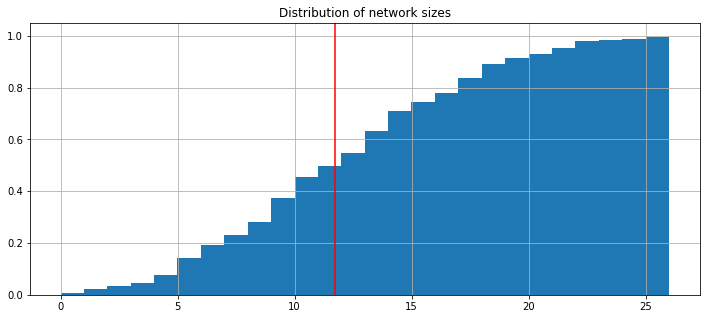

In [11]:
plt.hist(nets, cumulative=True, density=True, bins=2000)
plt.title('Distribution of network sizes')
plt.axvline(np.mean(nets), color='r')
plt.grid()

### Finally ready to simulate:

We will place the population that we have created, into various settings and societies in the upcoming simulations

In [12]:
POP_SIZE = 56000
PREVALENCE = 1/560 * 4
SCALE_SETTINGS = dict(n_days = 201, pop_size = POP_SIZE, seed_size = int(POP_SIZE*PREVALENCE), population=pop)
SCALE_SETTINGS

{'n_days': 201,
 'pop_size': 56000,
 'seed_size': 400,
 'population': <population.networks.household_workplace.HouseholdWorkplacePopulation at 0x25f28868860>}

Our baseline simulation is of a runaway infection.

We start with 400 people infected in a population of 56,000.

We begin by studying a society where people don't know whether or how to self-isolate:

In [13]:
s_basic = society.Society(config=dict(PROB_ISOLATE_IF_SYMPTOMS = 0))
o_basic = Outbreak(s_basic, Covid(), **SCALE_SETTINGS).simulate()

2020-12-06 10:27:02,183 WARNING:Using a pre-existing population - does it have the right network structure?
2020-12-06 10:27:03,009 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0051
2020-12-06 10:27:08,789 INFO:Day 51, prop infected is 0.36, prop infectious is 0.0776
2020-12-06 10:27:15,007 INFO:Day 101, prop infected is 0.64, prop infectious is 0.0124
2020-12-06 10:27:20,066 INFO:Day 151, prop infected is 0.65, prop infectious is 0.0003
2020-12-06 10:27:24,919 INFO:Day 201, prop infected is 0.65, prop infectious is 0.0000


2020-12-06 10:27:25,368 INFO:Realized R0 of early infections is 1.43
2020-12-06 10:27:25,369 INFO:65.1 percent of the proportion was infected during the epidemic


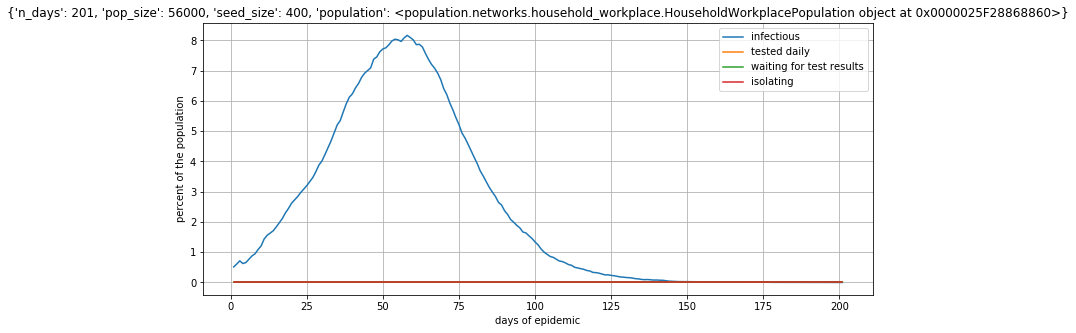

In [14]:
o_basic.plot(title=str(SCALE_SETTINGS))

Lets put that on a log scale:

2020-12-06 10:27:25,740 INFO:Realized R0 of early infections is 1.43
2020-12-06 10:27:25,741 INFO:65.1 percent of the proportion was infected during the epidemic


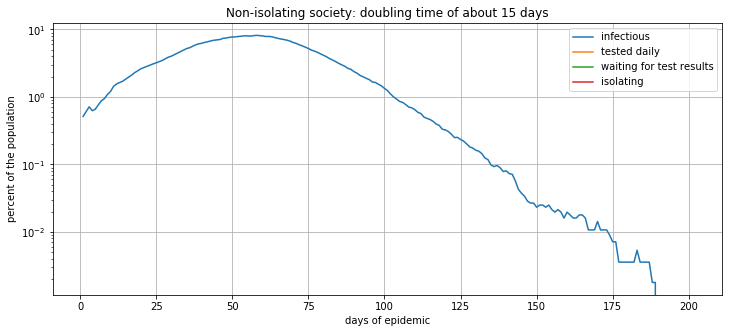

In [15]:
o_basic.plot(logy=True, title='Non-isolating society: doubling time of about 15 days')

Next, suppose that people know to isolate if they show symptoms, and 75% do so - this is similar to what is going on in the UK now:

In [16]:
s_isolate = society.Society(config=dict(PROB_ISOLATE_IF_SYMPTOMS = 0.75))
o_isolate = Outbreak(s_isolate, Covid(), **SCALE_SETTINGS).simulate()

2020-12-06 10:27:26,541 WARNING:Using a pre-existing population - does it have the right network structure?
2020-12-06 10:27:27,413 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0052
2020-12-06 10:27:35,212 INFO:Day 51, prop infected is 0.06, prop infectious is 0.0056
2020-12-06 10:27:43,180 INFO:Day 101, prop infected is 0.09, prop infectious is 0.0034
2020-12-06 10:27:49,795 INFO:Day 151, prop infected is 0.10, prop infectious is 0.0015
2020-12-06 10:27:55,877 INFO:Day 201, prop infected is 0.11, prop infectious is 0.0011


2020-12-06 10:27:56,602 INFO:Realized R0 of early infections is 1.02
2020-12-06 10:27:56,604 INFO:11.0 percent of the proportion was infected during the epidemic


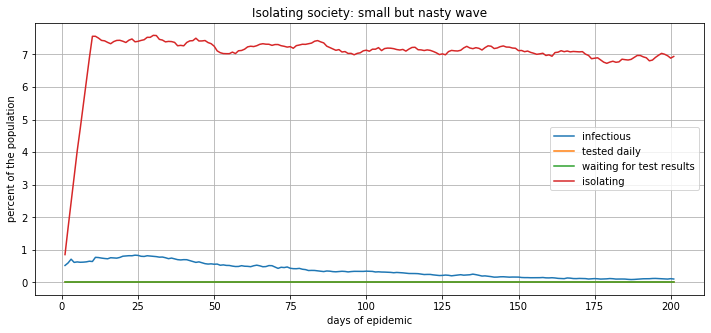

In [17]:
o_isolate.plot(title='Isolating society: small but nasty wave')

So, now we can add testing:
 * initially, here, lets suppose that positive test results are just ignored, while -ve results let people out of isolation:

In [18]:
s_testignored = society.TestingSociety(config=dict(PROB_ISOLATE_IF_TESTPOS=0))
o_testignored = Outbreak(s_testignored, Covid(), **SCALE_SETTINGS).simulate()

2020-12-06 10:27:57,379 WARNING:Using a pre-existing population - does it have the right network structure?
2020-12-06 10:27:58,747 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0051
2020-12-06 10:28:05,933 INFO:Day 51, prop infected is 0.08, prop infectious is 0.0101
2020-12-06 10:28:13,175 INFO:Day 101, prop infected is 0.15, prop infectious is 0.0083
2020-12-06 10:28:19,920 INFO:Day 151, prop infected is 0.18, prop infectious is 0.0031
2020-12-06 10:28:26,826 INFO:Day 201, prop infected is 0.20, prop infectious is 0.0018


2020-12-06 10:28:27,007 INFO:Realized R0 of early infections is 1.08
2020-12-06 10:28:27,008 INFO:19.6 percent of the proportion was infected during the epidemic


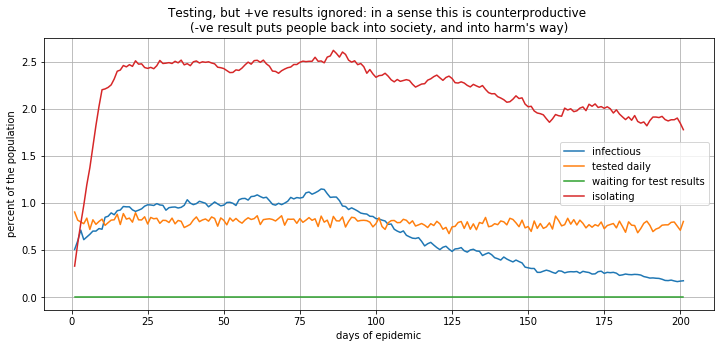

In [19]:
o_testignored.plot(title="Testing, but +ve results ignored: in a sense this is counterproductive \n"
                         "(-ve result puts people back into society, and into harm's way)")

 * Now suppose that people respond to test results, some of the time:

In [20]:
o_test = Outbreak(society.TestingSociety(), Covid(), **SCALE_SETTINGS).simulate()

2020-12-06 10:28:27,391 WARNING:Using a pre-existing population - does it have the right network structure?
2020-12-06 10:28:28,244 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0052
2020-12-06 10:28:35,507 INFO:Day 51, prop infected is 0.07, prop infectious is 0.0089
2020-12-06 10:28:42,416 INFO:Day 101, prop infected is 0.11, prop infectious is 0.0052
2020-12-06 10:28:49,021 INFO:Day 151, prop infected is 0.14, prop infectious is 0.0027
2020-12-06 10:28:56,382 INFO:Day 201, prop infected is 0.16, prop infectious is 0.0016


2020-12-06 10:28:56,559 INFO:Realized R0 of early infections is 1.08
2020-12-06 10:28:56,559 INFO:15.7 percent of the proportion was infected during the epidemic


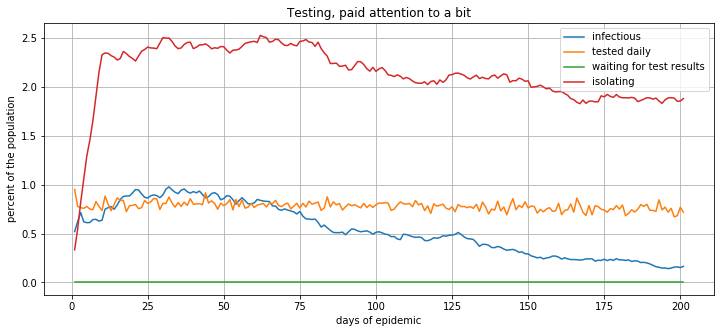

In [21]:
o_test.plot(title="Testing, paid attention to a bit")

We add contact-tracing and isolation:

In [22]:
o_test_trace = Outbreak(society.TestingTracingSociety(), Covid(), **SCALE_SETTINGS).simulate()

2020-12-06 10:28:56,874 WARNING:Using a pre-existing population - does it have the right network structure?
2020-12-06 10:28:57,753 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0053
2020-12-06 10:29:04,937 INFO:Day 51, prop infected is 0.05, prop infectious is 0.0038
2020-12-06 10:29:12,005 INFO:Day 101, prop infected is 0.06, prop infectious is 0.0005
2020-12-06 10:29:18,760 INFO:Day 151, prop infected is 0.06, prop infectious is 0.0000
2020-12-06 10:29:25,169 INFO:Day 201, prop infected is 0.06, prop infectious is 0.0000


2020-12-06 10:29:25,323 INFO:Realized R0 of early infections is 0.92
2020-12-06 10:29:25,324 INFO:5.9 percent of the proportion was infected during the epidemic


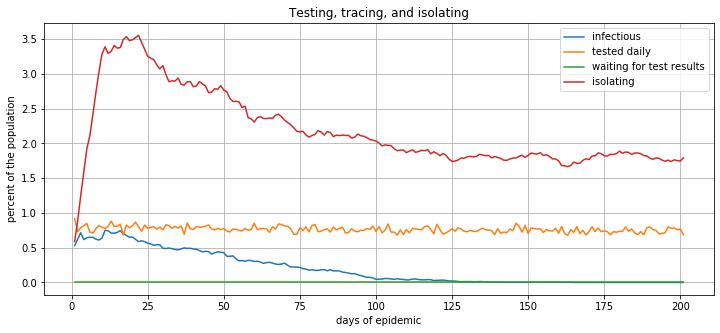

In [23]:
o_test_trace.plot(title='Testing, tracing, and isolating', secondary_y=['prop_infected'])

UK society, however, is characterized by testing bottlenecks:

In [24]:
import society.alternatives
o_UK = Outbreak(society.alternatives.UKSociety(), Covid(), **SCALE_SETTINGS).simulate()

2020-12-06 10:29:25,623 WARNING:Using a pre-existing population - does it have the right network structure?
2020-12-06 10:29:26,480 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0052
2020-12-06 10:29:33,398 INFO:Day 51, prop infected is 0.03, prop infectious is 0.0016
2020-12-06 10:29:39,897 INFO:Day 101, prop infected is 0.04, prop infectious is 0.0005
2020-12-06 10:29:46,703 INFO:Day 151, prop infected is 0.04, prop infectious is 0.0001
2020-12-06 10:29:53,174 INFO:Day 201, prop infected is 0.04, prop infectious is 0.0000


2020-12-06 10:29:53,331 INFO:Realized R0 of early infections is 0.83
2020-12-06 10:29:53,331 INFO:4.3 percent of the proportion was infected during the epidemic


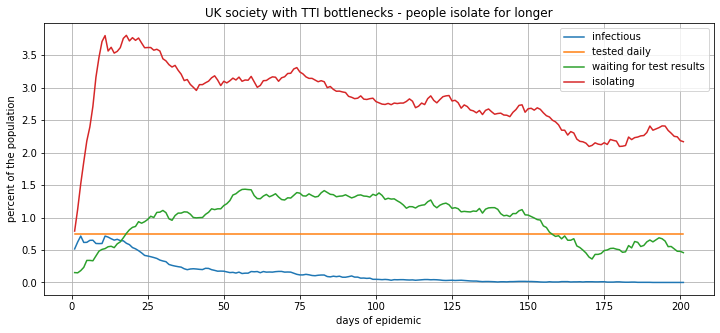

In [25]:
o_UK.plot(title='UK society with TTI bottlenecks - people isolate for longer')

In [26]:
o_contact_test = Outbreak(society.ContactTestingSociety(), Covid(), **SCALE_SETTINGS).simulate()

2020-12-06 10:29:53,639 WARNING:Using a pre-existing population - does it have the right network structure?
2020-12-06 10:29:54,492 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0051
2020-12-06 10:30:02,063 INFO:Day 51, prop infected is 0.04, prop infectious is 0.0033
2020-12-06 10:30:09,408 INFO:Day 101, prop infected is 0.05, prop infectious is 0.0007
2020-12-06 10:30:16,291 INFO:Day 151, prop infected is 0.05, prop infectious is 0.0001
2020-12-06 10:30:22,297 INFO:Day 201, prop infected is 0.06, prop infectious is 0.0000


2020-12-06 10:30:22,436 INFO:Realized R0 of early infections is 0.96
2020-12-06 10:30:22,437 INFO:5.5 percent of the proportion was infected during the epidemic


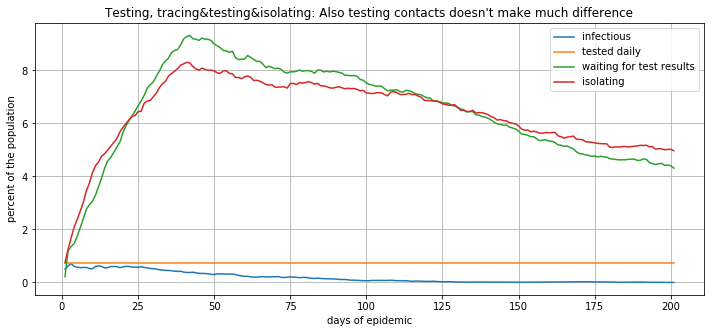

In [27]:
o_contact_test.plot(title="Testing, tracing&testing&isolating: "
                    "Also testing contacts doesn't make much difference", 
                    secondary_y=['prop_infected'])

In [28]:
infector_nets = [len(p.infector.contacts) for p in pop.people if p.infector]

In [29]:
infected_nets = [len(p.contacts) for p in pop.people if p.infected]

In [30]:
def most_connected_infector(guy):
    if guy.infector is None:
        raise NotImplementedError
    return max([len(i.contacts) for i in guy.chain() if i is not guy]) 

max_contacts_chain = [most_connected_infector(person)
                      for person in pop.people 
                      if person.infector is not None]

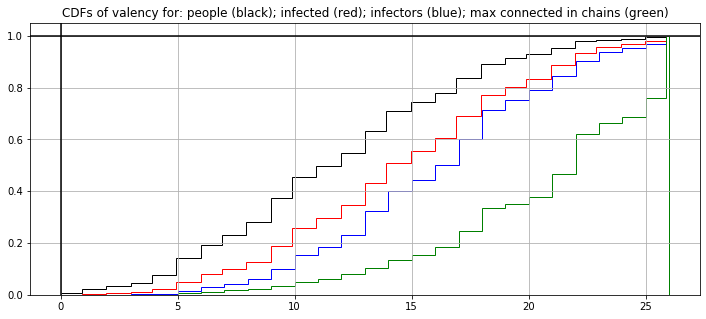

In [31]:
opts = dict(cumulative=True, bins=200, density=True, histtype='step')

plt.hist(nets, color='k', **opts)
plt.hist(infected_nets, color='r', **opts)
plt.hist(infector_nets, color='b', **opts)
plt.hist(max_contacts_chain, color='g', **opts)

plt.title("CDFs of valency for: people (black); infected (red); infectors (blue); max connected in chains (green)")
plt.axhline(1, color='k'); plt.axvline(0, color='k')
plt.grid()